In [1]:
import porespy.generators as generator
import matplotlib.pyplot as plt

In [2]:
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from scipy.ndimage import label
from skimage.segmentation import watershed

from skimage.measure import regionprops
import numpy as np

In [3]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d


In [4]:
shape = [1000, 1000]
blobns = 2
porosity = 0.3
phantom = generator.blobs(shape, porosity= 1 - porosity, blobiness=blobns)


(-0.5, 999.5, 999.5, -0.5)

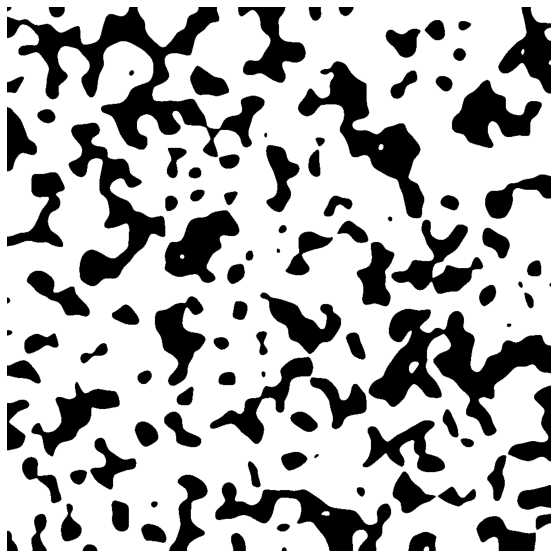

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(phantom, cmap='gray')
ax.axis("off")

In [6]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

In [7]:
# local_maxima = peak_local_max(dtf_img, indices=False, min_distance=20)
# markers, _ = label(local_maxima)#, np.ones((3, 3, 3)))
# labels = watershed(-dtf_img, markers, mask=~phantom)

# markers, _ = label(local_maxima)#, np.ones((3, 3, 3)))
labels, _ = label(~phantom)

Number of labels: 107


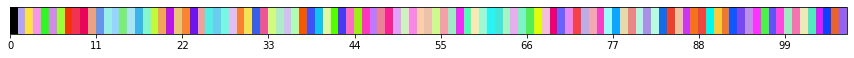

In [8]:
my_cmap = rand_cmap(np.max(labels), type='bright', first_color_black=True, last_color_black=False, verbose=True)

(-0.5, 999.5, 999.5, -0.5)

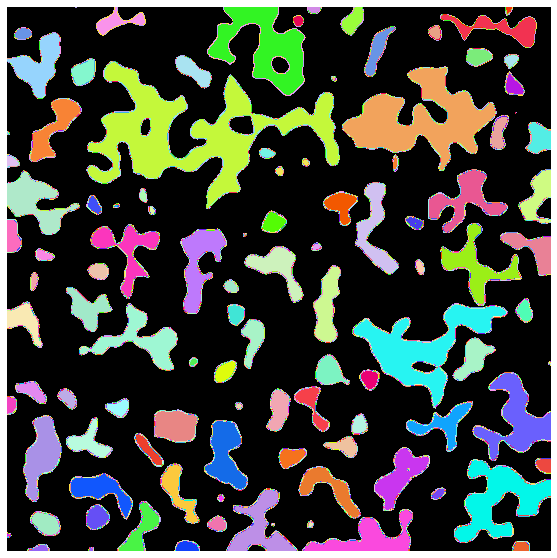

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(labels, cmap=my_cmap)
ax.axis("off")

In [10]:
regions=regionprops(labels)

In [11]:
volumes = [r.area for r in regions if r.area>1]

In [12]:
def plot_volume_hist(volume_distribution,
                     num_of_bins=35,
                     max_x_value=None,
                     log_scale=False,
                     alpha=0.5,
                     color="blue",
                     ax=None):

    max_x_value = np.max(volume_distribution) if not max_x_value else max_x_value
    bins = np.linspace(0, max_x_value, num_of_bins+1)

    ax.hist(volume_distribution,
            bins=bins,
            log=log_scale,
            alpha=alpha,
            color=color,
            edgecolor='k')

    ax.set_title(f'volume distribution')
    ax.set_xlabel('volume in voxels')
    ax.set_ylabel('number')
    ax.grid()

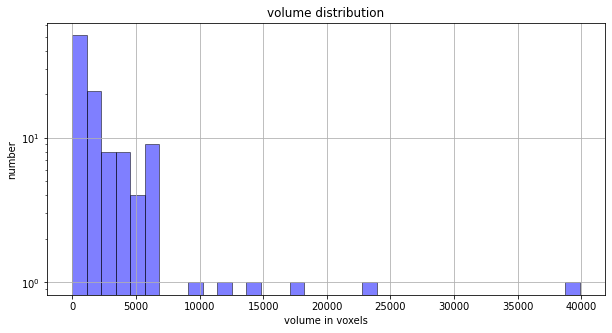

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
plot_volume_hist(volumes,
                 num_of_bins=35,
                 max_x_value=None,
                 log_scale=True,
                 ax=ax)

In [14]:
def plot_hists_for_one_type_phantom(blobns, iterations=3, porosity=0.3, shape = [1000, 1000]):
    fig, (axes0, axes1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1.5]}, figsize=(13,5))
    colors = ['red', "black", "purple"]
    for k in range(iterations):
        phantom = generator.blobs(shape, porosity= 1 - porosity, blobiness=blobns)
        if k==0:
            axes0.imshow(phantom, cmap='gray')
            axes0.set_title(f"a phantom blobns = {blobns}")
        labels, _ = label(~phantom)
        regions=regionprops(labels)
        volumes = [r.area for r in regions if r.area>1]

        plot_volume_hist(volumes,
                         num_of_bins=35,
                         max_x_value=None,
                         log_scale=False,
                         ax=axes1)
        axes1.axvline(x=np.median(volumes), color=colors[k], label=f"median {k+1}")
    axes1.legend()
    plt.tight_layout()

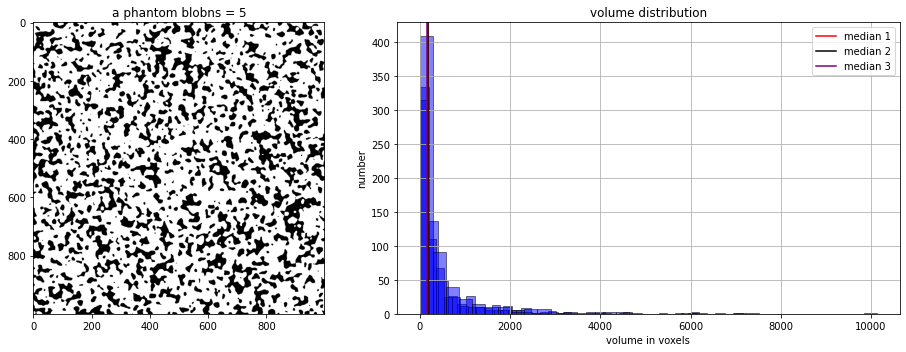

In [15]:
plot_hists_for_one_type_phantom(blobns=5, porosity=0.3, shape = [1000, 1000])

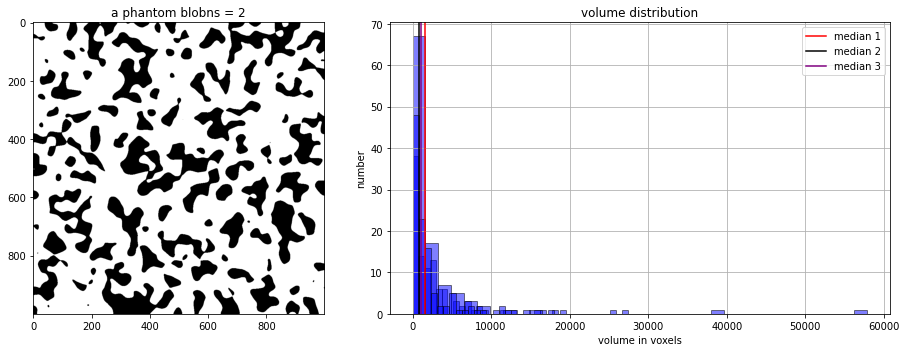

In [16]:
plot_hists_for_one_type_phantom(blobns=2, porosity=0.3, shape = [1000, 1000])

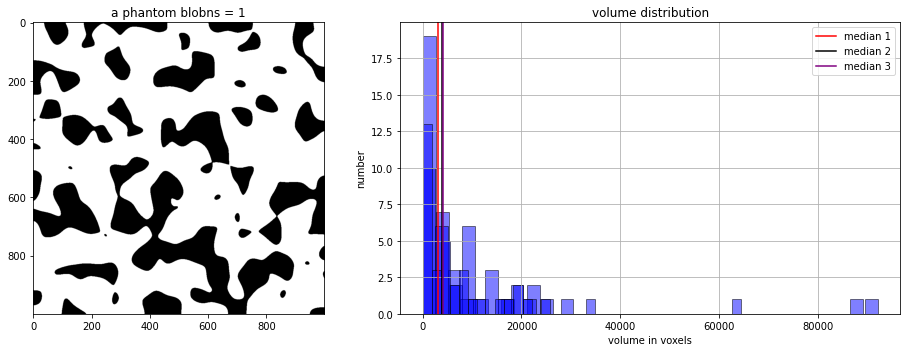

In [17]:
plot_hists_for_one_type_phantom(blobns=1, porosity=0.3, shape = [1000, 1000])

In [30]:
def plot_hists_for_different_type_phantoms(blobns_arr, porosity=0.3, shape = [1000, 1000], norm=True, max_hist_value=10_000):
    number_of_phantoms=len(blobns_arr)
    nrows = np.ceil(number_of_phantoms/2).astype(int)
    ncols = 2
    scale = 7
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize = (nrows*scale, ncols*scale))

    last_axis_index = nrows * 2 - 1
    axes=axes.ravel()
    colors = ['red', "black", "purple", "green", "blue"]

    phantoms = []
    for k, (ax, blobns) in enumerate(zip(axes, blobns_arr)):
        phantom = generator.blobs(shape, porosity= 1 - porosity, blobiness=blobns)
        if not k==last_axis_index:
            ax.imshow(phantom, cmap='gray')
            ax.set_title(f"a phantom blobns = {blobns}")
        phantoms.append(phantom)
        
    for color_num, (blobns, phantom) in enumerate(zip(blobns_arr, phantoms)):
        labels, _ = label(~phantom)
        regions=regionprops(labels)
        volumes = np.asarray([r.area for r in regions if r.area>1])

        volumes = volumes / np.max(volumes) if norm else volumes
        

        plot_volume_hist(volumes,
                         num_of_bins=35,
                         log_scale=True,
                         alpha=0.3,
                         max_x_value=max_hist_value,
                         color=colors[color_num],
                         ax=axes[-1])

        median_coord = np.median(volumes)
        axes[-1].axvline(x=median_coord,
                         color=colors[color_num],
                         label=f"median blobns = {blobns}: {median_coord}")
    axes[-1].legend()
    plt.tight_layout()

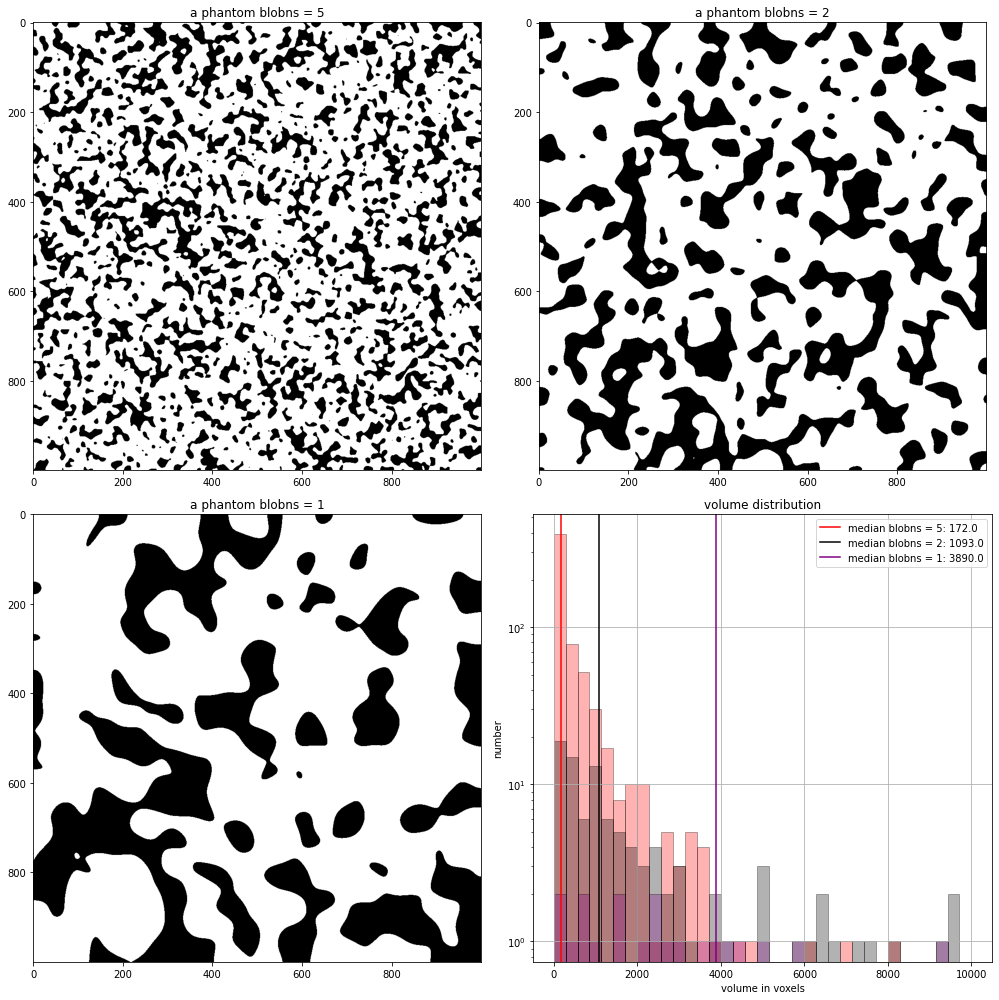

In [31]:
plot_hists_for_different_type_phantoms(blobns_arr=[5,2,1], porosity=0.3, shape = [1000, 1000], norm=False)

In [6]:
def get_hist_median_for_pore_volumes_in_phantoms(blobns, porosity=0.1, shape = [1000, 1000]):
    phantom = generator.blobs(shape, porosity= 1 - porosity, blobiness=blobns)

    labels, _ = label(~phantom)
    regions=regionprops(labels)
    volumes = [r.area for r in regions if r.area>1]
    return np.median(volumes)


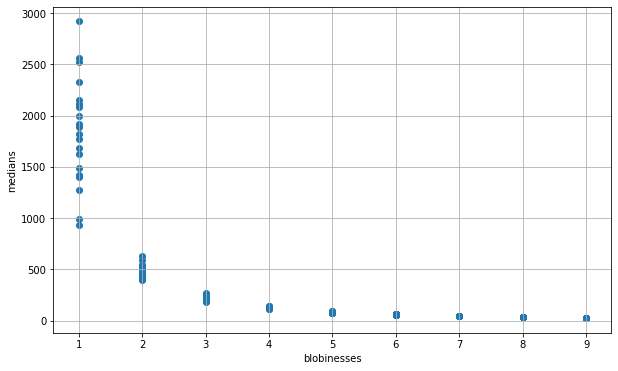

In [104]:
# only for demonstration
medians = []
blobinesses = []

for k in range(200):
    blobiness = np.random.randint(1, 10)
    medians.append(get_hist_median_for_pore_volumes_in_phantoms(blobns=blobiness))
    blobinesses.append(blobiness)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = blobinesses, y = medians)
ax.set_xlabel("blobinesses")
ax.set_ylabel("medians")
ax.grid()

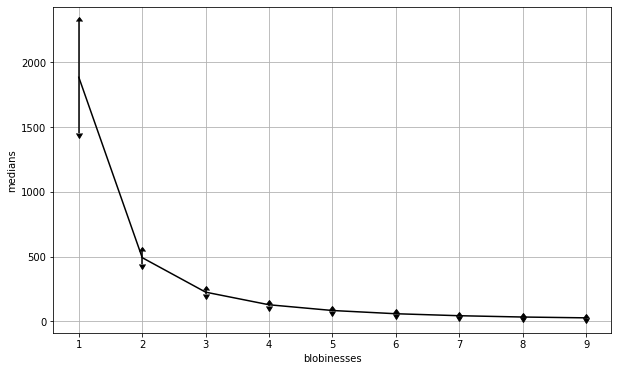

In [105]:

blobinesses = []
avg_medians = []
std_medians = []

for blobiness in range(1, 10):
    medians = []
    blobinesses.append(blobiness)
    for k in range(20):
        medians.append(get_hist_median_for_pore_volumes_in_phantoms(blobns=blobiness))
    avg_medians.append(np.mean(medians))
    std_medians.append(np.std(medians))

fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(blobinesses, avg_medians, uplims=True, lolims=True, yerr=std_medians, color="black")
ax.set_xlabel("blobinesses")
ax.set_ylabel("medians")
ax.grid()

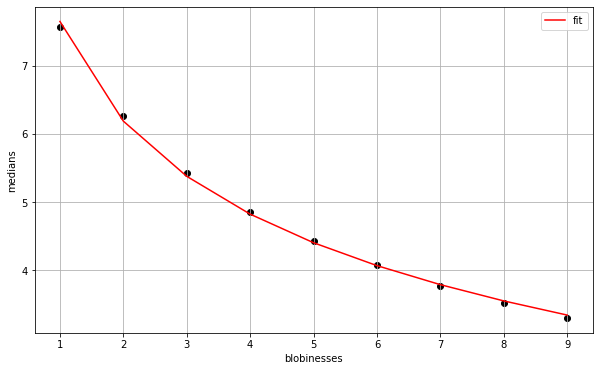

In [14]:
def func(x, a, b, c):
    x = np.asarray(x)
    return a / pow(x, b) + c

popt, pcov = curve_fit(func, blobinesses, np.log(avg_medians), bounds=([-np.inf, 0.1,-np.inf], [np.inf, 0.5, np.inf]))

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(blobinesses, np.log(avg_medians), color="black")
ax.set_xlabel("blobinesses")
ax.set_ylabel("medians")
ax.plot(blobinesses, func(blobinesses, *popt), 'r-',
         label='fit')
ax.grid()
ax.legend()

In [60]:
def find_intersection_of_curve_with_yconst(x, y, yconst):
    f2 = interp1d(x, y, kind='linear')
    x_new = np.linspace(np.min(x), np.max(x), num=100, endpoint=True)
    y_new = f2(x_new)
    _ = plt.figure(figsize=(20,10))
    indx = np.argmax(np.diff((y_new - yconst)>0))
    return (x_new[indx], yconst)


In [84]:
def generate_phantom_and_calculate_blobiness(blobns, porosity = 0.1):
    shape = [1000, 1000]

    phantom = generator.blobs(shape, porosity= 1 - porosity, blobiness=blobns)
    fig, axes = plt.subplots(ncols=3, figsize=(15,5))
    axes[0].imshow(phantom, cmap='gray')
    axes[0].set_title(f"initial phantom: blobns {blobns}")
    axes[0].axis("off")

    axes[1].plot(blobinesses, func(blobinesses, *popt), 'k-',
            label='fit')

    labels, _ = label(~phantom)
    regions=regionprops(labels)
    volumes = [r.area for r in regions if r.area>1]
    median_log = np.log(np.median(volumes))

    found_blobiness, _ = find_intersection_of_curve_with_yconst(blobinesses, func(blobinesses, *popt), median_log)
    axes[1].axhline(y=median_log,
                    color="red")
    axes[1].axvline(x=found_blobiness,
                    color="red")
    axes[1].plot([found_blobiness], [median_log], 'o', markersize=10)
    axes[1].grid()
    axes[1].axis("on")
    axes[1].set_xlabel("blobiness")
    axes[1].set_ylabel("median(volume dist)")
    axes[1].set_title("intersection point")

    axes[2].imshow(generator.blobs(shape, porosity= 1 - porosity, blobiness=found_blobiness), cmap='gray')
    axes[2].set_title(f"new phantom blobiness: {found_blobiness:.2f}")
    axes[2].axis("off")

    func(blobns, *popt)

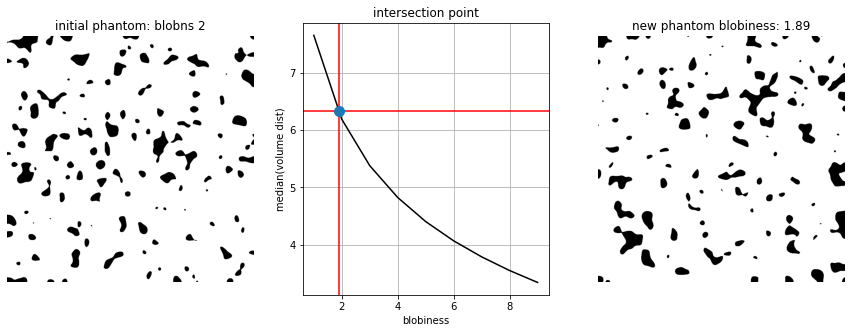

<Figure size 1440x720 with 0 Axes>

In [85]:
generate_phantom_and_calculate_blobiness(2)

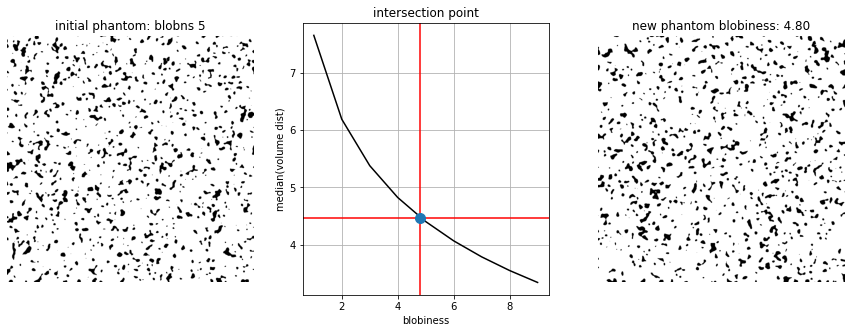

<Figure size 1440x720 with 0 Axes>

In [86]:
generate_phantom_and_calculate_blobiness(5)

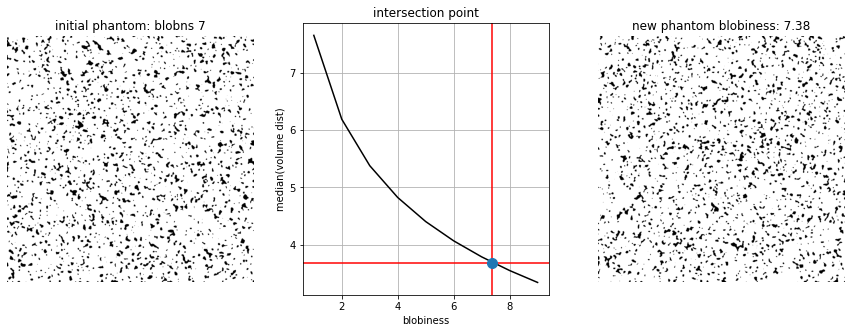

<Figure size 1440x720 with 0 Axes>

In [88]:
generate_phantom_and_calculate_blobiness(7)


# without log norm

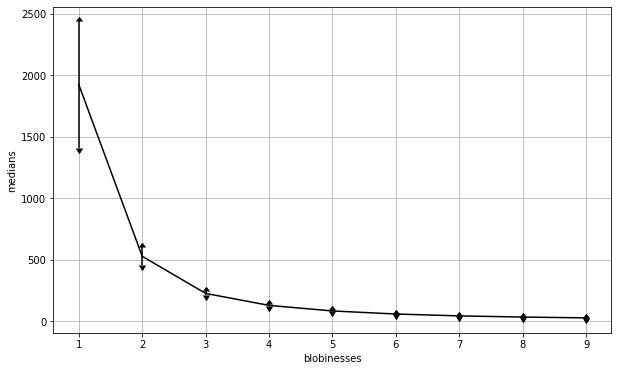

In [89]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(blobinesses, avg_medians, uplims=True, lolims=True, yerr=std_medians, color="black")
ax.set_xlabel("blobinesses")
ax.set_ylabel("medians")
ax.grid()

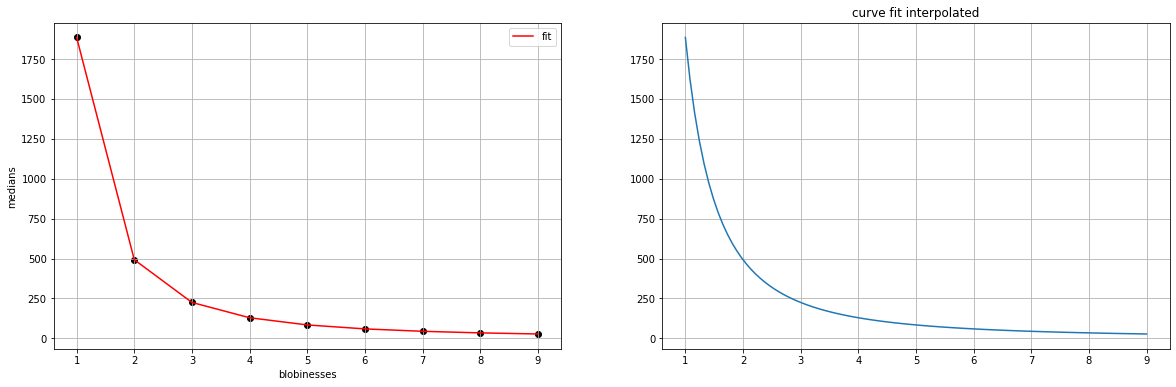

In [112]:
def func(x, a, b, c):
    x = np.asarray(x)
    return a / pow(x, b) + c

popt, pcov = curve_fit(func, blobinesses, avg_medians)

fig, axes = plt.subplots(ncols=2, figsize=(20, 6))
axes[0].scatter(blobinesses, avg_medians, color="black")
axes[0].set_xlabel("blobinesses")
axes[0].set_ylabel("medians")
axes[0].plot(blobinesses, func(blobinesses, *popt), 'r-', label='fit')

x = np.linspace(np.min(blobinesses), np.max(blobinesses), num=100, endpoint=True)
axes[1].plot(x, func(x, *popt))
axes[1].set_title("curve fit interpolated")

for ax in axes:
    ax.grid()

axes[0].legend()

In [121]:
def generate_phantom_and_calculate_blobiness_without_log(blobns, porosity = 0.1):
    shape = [1000, 1000]

    phantom = generator.blobs(shape, porosity= 1 - porosity, blobiness=blobns)
    fig, axes = plt.subplots(ncols=3, figsize=(15,5))
    axes[0].imshow(phantom, cmap='gray')
    axes[0].set_title(f"initial phantom: blobns {blobns}")
    axes[0].axis("off")

    axes[1].plot(blobinesses, func(blobinesses, *popt), 'k-',
            label='fit')

    labels, _ = label(~phantom)
    regions=regionprops(labels)
    volumes = [r.area for r in regions if r.area>1]
    median = np.median(volumes)

    found_blobiness, _ = find_intersection_of_curve_with_yconst(blobinesses, func(blobinesses, *popt), median)
    axes[1].axhline(y=median,
                    color="red")
    axes[1].axvline(x=found_blobiness,
                    color="red")
    axes[1].plot([found_blobiness], [median], 'o', markersize=10)
    axes[1].grid()
    axes[1].axis("on")
    axes[1].set_xlabel("blobiness")
    axes[1].set_ylabel("median(volume dist)")
    axes[1].set_title("intersection point")

    axes[2].imshow(generator.blobs(shape, porosity= 1 - porosity, blobiness=found_blobiness), cmap='gray')
    axes[2].set_title(f"new phantom blobiness: {found_blobiness:.2f}")
    axes[2].axis("off")

    func(blobns, *popt)

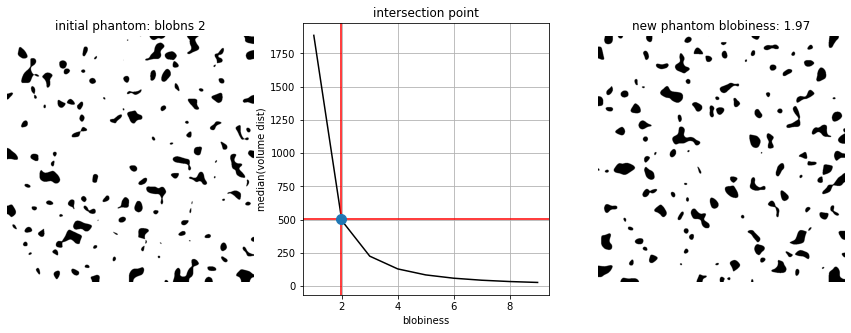

<Figure size 1440x720 with 0 Axes>

In [122]:
generate_phantom_and_calculate_blobiness_without_log(2)

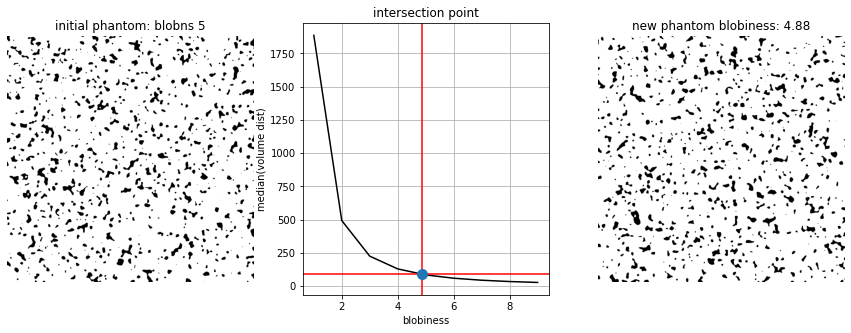

<Figure size 1440x720 with 0 Axes>

In [123]:
generate_phantom_and_calculate_blobiness_without_log(5)

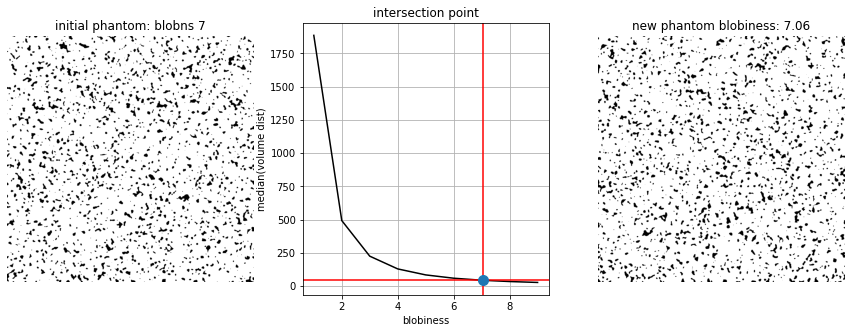

<Figure size 1440x720 with 0 Axes>

In [124]:
generate_phantom_and_calculate_blobiness_without_log(7)

# Full stack:

In [ ]:
def get_hist_median_for_pore_volumes_in_sample(blobiness,
                                               porosity=0.1,
                                               shape = [1000, 1000]):
    phantom = generator.blobs(shape, porosity=1-porosity, blobiness=blobiness)

    labels, _ = label(~phantom)
    regions = regionprops(labels)
    volumes = [r.area for r in regions if r.area>1]
    return np.median(volumes)


def get_avg_medians_graduation_curve(blobiness, porosity, shape):
    blobinesses = []
    avg_medians = []

    #TODO: choice of blobiness range should be more sensible:
    for blobiness in range(1, 10):
        medians = []
        blobinesses.append(blobiness)
        for k in range(20):
            medians.append(get_hist_median_for_pore_volumes_in_sample(blobiness, porosity, shape))
        avg_medians.append(np.mean(medians))

    return avg_medians


def generate_phantom_and_calculate_blobiness_without_log(blobiness,
                                                         porosity=0.1,
                                                         shape = [1000, 1000]):
    shape = [1000, 1000]

    phantom = generator.blobs(shape, porosity=1-porosity, blobiness=blobiness)
    fig, axes = plt.subplots(ncols=3, figsize=(15,5))
    axes[0].imshow(phantom, cmap='gray')
    axes[0].set_title(f"initial phantom: blobns {blobiness}")
    axes[0].axis("off")

    axes[1].plot(blobinesses, func(blobinesses, *popt), 'k-',
            label='fit')

    labels, _ = label(~phantom)
    regions=regionprops(labels)
    volumes = [r.area for r in regions if r.area>1]
    median = np.median(volumes)

    found_blobiness, _ = find_intersection_of_curve_with_yconst(blobinesses, func(blobinesses, *popt), median)
    axes[1].axhline(y=median,
                    color="red")
    axes[1].axvline(x=found_blobiness,
                    color="red")
    axes[1].plot([found_blobiness], [median], 'o', markersize=10)
    axes[1].grid()
    axes[1].axis("on")
    axes[1].set_xlabel("blobiness")
    axes[1].set_ylabel("median(volume dist)")
    axes[1].set_title("intersection point")

    axes[2].imshow(generator.blobs(shape, porosity= 1 - porosity, blobiness=found_blobiness), cmap='gray')
    axes[2].set_title(f"new phantom blobiness: {found_blobiness:.2f}")
    axes[2].axis("off")

    func(blobiness, *popt)